# Topology

GRANAD allows some topological calculations.

For a more in-depth discussion of skyrmions in condensed matter, see [Definition and statistical distributions of a topological number in the lattice O(3) σ-model](https://www.sciencedirect.com/science/article/abs/pii/055032138190568X).
For optical skyrmions (polarization textures), consider, e.g. the references [here](https://opg.optica.org/aop/abstract.cfm?uri=aop-17-2-295) or [here](https://link.aps.org/doi/10.1103/PhysRevA.102.053513).

In GRANAD, we focus on **optical polarization skyrmions** generated by structured light.

## Skyrmion fields

## Background

In a transverse plane of a paraxial beam, polarization is encoded by the (normalized) Stokes vector

$$\mathbf{s}(x,y) = (s_1,s_2,s_3) = \frac{1}{S_0}(S_1,S_2,S_3), \qquad |\mathbf{s}|=1.$$

This maps points in the plane to points on the Poincaré sphere. If the polarization tends to a constant
at the domain boundary, we can "roll up" the plane to a sphere. This is called ["compactification"](https://en.wikipedia.org/wiki/Compactification_(mathematics)). This mapping can carry a topological charge, called **Skyrmion number**

$$N = \frac{1}{4\pi}\int \mathbf{s}\cdot(\partial_x\mathbf{s}\times \partial_y\mathbf{s})\,dx\,dy.$$

Numerically, we compute the Skyrmion number using a triangulation/solid-angle method (Berg's method),
which is robust on discretized grids.

### Skyrmionic LG superpositions

The simplest optical skyrmion beams are paraxial superpositions of two Laguerre–Gaussian modes
with orthogonal polarization states and orbital angular momenta differing by one:

$$\mathbf{E}(x,y,z) = a_1\,u_{p_1}^{\ell_1}(x,y,z)\,\mathbf{e}_1 + a_2\,u_{p_2}^{\ell_2}(x,y,z)\,\mathbf{e}_2,
\qquad \Delta\ell = \ell_2-\ell_1 = 1.$$

Here \(u_p^\ell\) is a scalar LG mode in the paraxial approximation, and \(\mathbf{e}_{1,2}\) are orthogonal
polarization vectors (by default right/left circular polarization in GRANAD's convention).

In [1]:
### Initialize a Skyrmion field
#
# We initialize a Skyrmionic field like this:

In [2]:
from granad import *
import jax.numpy as jnp

a_1, a_2 = 1, 1
l1, l2 = 0, 1
p1, p2 = 0, 0
w0 = 20
wavelength = 1

e_field = Skyrmion(a_1, a_2, l1, l2, p1, p2, w0, wavelength)

In [3]:
# The function `e_field(xs, ys, z)` computes the complex electric field on a grid and returns an
# array of shape ``(Nx, Ny, 3)`` (x, y, z components).

In [4]:
a = 80
xs = jnp.linspace(-a, a, 600)
ys = jnp.linspace(-a, a, 600)

print(e_field(xs, ys, 0).shape)  # evaluate at z = 0 plane

(600, 600, 3)


In [5]:
## Stokes vector
#
# The topological invariant is carried by the Stokes vector. We compute Stokes parameters by projecting
# the electric field onto circular polarization basis vectors \( \mathbf{e}_r, \mathbf{e}_l \).
#
# The resulting Stokes field has shape ``(Nx, Ny, 4)`` with components ``[S0, S1, S2, S3]``.

In [6]:
f_sv = stokes_vector(e_field)
sv = f_sv(xs, ys, 0)

print(sv.shape)

(600, 600, 4)


In [7]:
### Visualizing the Stokes vector
#
# We visualize the normalized Stokes vector \( \mathbf{s} = (S_1,S_2,S_3)/S_0 \).

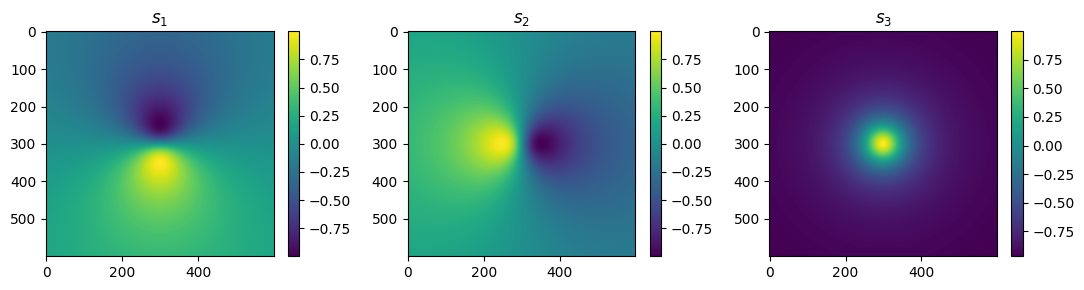

In [8]:
import matplotlib.pyplot as plt

S0 = sv[:, :, 0]
sv_norm = sv[:, :, 1:] / S0[:, :, None]

fig, axs = plt.subplots(1, 3, figsize=(11, 3))
im0 = axs[0].imshow(sv_norm[:, :, 0], aspect="auto")
axs[0].set_title(r"$s_1$")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(sv_norm[:, :, 1], aspect="auto")
axs[1].set_title(r"$s_2$")
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(sv_norm[:, :, 2], aspect="auto")
axs[2].set_title(r"$s_3$")
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

We typically observe \( \mathbf{s}\approx(0,0,1) \) (north pole) near the beam center, and
\( \mathbf{s}\approx(0,0,-1) \) (south pole) near the boundary of a sufficiently large domain.
If the polarization approaches a constant at the boundary, the plane effectively wraps the sphere,
and the Skyrmion number becomes (close to) an integer.

In [9]:
# ## Computing the Skyrmion number (Berg triangulation)
#
# For general fields, we compute the Skyrmion number numerically using a solid-angle/triangulation
# method. This is robust on grids, but **requires**:
#
# 1. A sufficiently large spatial window so the polarization is essentially constant at the boundary.
# 2. Masking of very small intensities where \(S_0\) is close to zero (otherwise normalization is noisy).
#
# GRANAD implements a masked Berg sum through `get_skyrmion_number`.

In [10]:
print(get_skyrmion_number(sv))

0.9750569116451913


In [11]:
## More examples
#
### Trivial case (no topology)
#
# If the two components have the same OAM, the texture is topologically trivial.

In [12]:
l1, l2 = 1, 1
e_field = Skyrmion(a_1, a_2, l1, l2, p1, p2, w0, wavelength)

f_sv = stokes_vector(e_field)
sv = f_sv(xs, ys, 0)

print(get_skyrmion_number(sv))  # should be ~ 0 because Δℓ = 0

0.0


In [13]:
# ### Higher charge
#
# Increasing the OAM difference increases the winding. For example, Δℓ = 3 should give ~3.

In [14]:
l1, l2 = 1, 4
e_field = Skyrmion(a_1, a_2, l1, l2, p1, p2, w0, wavelength)

f_sv = stokes_vector(e_field)
sv = f_sv(xs, ys, 0)

print(get_skyrmion_number(sv))  # should be ~ 3 because Δℓ = 3

2.99994467849779


In [15]:
## Skyrmion fields in time propagation
#
# If you want to use a Skyrmionic beam as an external illumination in time-domain simulations,
# pass a `flake` to `Skyrmion(...)`. GRANAD then evaluates the (complex) spatial field once at the
# flake positions and returns a real time-harmonic field function.
#
# Example: illuminate a graphene flake in the dipole gauge:

In [16]:
flake = MaterialCatalog.get("graphene").cut_flake(Hexagon(10))
flake.shift_by_vector(-flake.positions[flake.center_index])

# Example skyrmion illumination (choose indices and waist as desired)
l1, l2 = 0, 1
e_field = Skyrmion(a_1, a_2, l1, l2, p1, p2, w0, wavelength, flake=flake)

operators = [flake.dipole_operator, flake.velocity_operator]
result = flake.master_equation(
    relaxation_rate=1/10,
    illumination=e_field,
    expectation_values=operators,
    end_time=40,
)

RHS compiled
RHS compiled


49.99262428086739 %


100.0 %
